## Connecting to database

In [1]:
import psycopg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
from pathlib import Path

current_dir = Path().resolve()
data_path = current_dir.joinpath('Data').resolve()

ori_pickle_file_path  = data_path.joinpath('movies_df_original.pkl').resolve()
cleaned_pickle_file_path = data_path.joinpath('movies_df_cleaned.pkl').resolve()

load_dotenv()

netid = os.getenv('netid')
password = os.getenv('password')

# define the connection parameters
dbname = 'everything2024'
user = netid
password = password
host = 'pg.mlds.northwestern.edu'
port = '5432' 

In [2]:
connection = psycopg.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host,
    port=port
)

In [3]:
cursor = connection.cursor()
cursor.execute(
    """
    select * from mlds422.movies;

    """
)

result = cursor.fetchall()


In [4]:
movies_df = pd.DataFrame(result, columns = [column[0] for column in cursor.description])

In [5]:
## Svae data to pkl file

# movies_df.to_pickle(ori_pickle_file_path)

# print("DataFrame saved to 'movies_df.pkl'")

# movies_df = pd.read_pickle(ori_pickle_file_path)


## EDA

In [6]:
display(movies_df.head())
movies_df.info()

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count
0,1,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,2010-02-12,2010-06-29,83.0,49,144,53.0,254287.0
1,2,Please Give,Kate has a lot on her mind. There's the ethics...,R,Comedy,Nicole Holofcener,2010-04-30,2010-10-19,90.0,86,140,64.0,11567.0
2,3,10,Blake Edwards' 10 stars Dudley Moore as George...,R,"Comedy, Romance",Blake Edwards,1979-10-05,1997-08-27,118.0,68,22,53.0,14670.0
3,4,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",None,"Classics, Drama",Sidney Lumet,2057-04-13,2001-03-06,95.0,100,51,97.0,105000.0
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,2054-01-01,2003-05-20,127.0,89,27,74.0,68860.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            16638 non-null  int64  
 1   movie_title         16638 non-null  object 
 2   movie_info          16614 non-null  object 
 3   rating              11776 non-null  object 
 4   genre               16621 non-null  object 
 5   directors           16524 non-null  object 
 6   in_theaters_date    15823 non-null  object 
 7   on_streaming_date   16636 non-null  object 
 8   runtime_in_minutes  16483 non-null  float64
 9   critic_rating       16638 non-null  int64  
 10  critic_count        16638 non-null  int64  
 11  audience_rating     16381 non-null  float64
 12  audience_count      16386 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 1.7+ MB


### 1. Find the number of movies that were released in theatres each year.

In [7]:
# Convert in_theaters_date to datetime
movies_df['in_theaters_date'] = pd.to_datetime(movies_df['in_theaters_date'])
movies_df['on_streaming_date'] = pd.to_datetime(movies_df['on_streaming_date'])
# Chekck erroneous values
display(movies_df['in_theaters_date'].min())
display(movies_df['in_theaters_date'].max())
display(movies_df[movies_df['in_theaters_date'].dt.year > 2024])

# They are wrong in century, they should be 20th century not 21st
# Fix by -100 in year
movies_df['in_theaters_date'] = movies_df['in_theaters_date'].apply(lambda x : x.replace(year=x.year-100) if x.year >2024 else x)

# Check if erroneous values are fixed
display(movies_df[movies_df['in_theaters_date'].dt.year > 2024])

Timestamp('1970-01-01 00:00:00')

Timestamp('2069-12-31 00:00:00')

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count
3,4,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",None,"Classics, Drama",Sidney Lumet,2057-04-13,2001-03-06,95.0,100,51,97.0,105000.0
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,2054-01-01,2003-05-20,127.0,89,27,74.0,68860.0
6,7,The 39 Steps,A man in London tries to help a counterespiona...,None,"Action & Adventure, Classics, Mystery & Suspense",Alfred Hitchcock,2035-08-01,2035-06-06,87.0,96,47,86.0,23827.0
7,8,3:10 to Yuma,"Desperate for money, frontier rancher Van Hefl...",None,"Classics, Drama, Western",Delmer Daves,2057-08-07,2002-04-02,92.0,96,27,78.0,9224.0
9,10,Abraham Lincoln,"To date, this D.W. Griffith epic is the only t...",None,"Classics, Drama",D.W. Griffith,2030-11-08,2008-11-18,97.0,90,10,38.0,455.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16572,16572,Young Mr. Lincoln,"In this biography of Abraham Lincoln, the Pres...",None,"Classics, Drama",John Ford,2039-06-09,2006-02-14,100.0,100,22,81.0,2298.0
16574,16574,The Young Savages,The Young Savages is what used to be called a ...,None,"Classics, Drama",John Frankenheimer,2061-05-24,2014-09-23,110.0,50,6,47.0,152.0
16600,16600,Z,"Based on true events, 'Z' is the award-winning...",PG,"Art House & International, Drama, Mystery & Su...",Costa-Gavras,2069-02-26,2002-07-02,128.0,93,42,93.0,6506.0
16635,16636,Zorba the Greek,If ever there was a role that Anthony Quinn wa...,None,"Action & Adventure, Art House & International,...",None,2064-12-17,2004-08-03,142.0,78,9,87.0,7126.0


,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count


In [8]:
# 815 null values in in_theaters_date
movies_df['in_theaters_date'].isna().sum()

# Missing value tittles
movies_df[movies_df['in_theaters_date'].isna()]['movie_title']
movies_df[movies_df['in_theaters_date'].isna()]['on_streaming_date'].isna().sum()

np.int64(2)

In [9]:
from importlib import reload
import tmdbmovie  
reload(tmdbmovie)

from tmdbmovie import update_release_dates
update_release_dates(movies_df)


,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count
0,1,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,2010-02-12,2010-06-29,83.0,49,144,53.0,254287.0
1,2,Please Give,Kate has a lot on her mind. There's the ethics...,R,Comedy,Nicole Holofcener,2010-04-30,2010-10-19,90.0,86,140,64.0,11567.0
2,3,10,Blake Edwards' 10 stars Dudley Moore as George...,R,"Comedy, Romance",Blake Edwards,1979-10-05,1997-08-27,118.0,68,22,53.0,14670.0
3,4,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",None,"Classics, Drama",Sidney Lumet,1957-04-13,2001-03-06,95.0,100,51,97.0,105000.0
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,1954-01-01,2003-05-20,127.0,89,27,74.0,68860.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16633,16633,Zoom,Former superhero Jack is called back to work t...,PG,"Action & Adventure, Comedy, Kids & Family",Peter Hewitt,2006-08-11,2007-09-02,88.0,3,66,33.0,11327.0
16634,16635,Zootopia,The modern mammal metropolis of Zootopia is a ...,PG,"Action & Adventure, Animation, Comedy","Byron Howard, Rich Moore, Jared Bush",2016-03-04,2016-06-07,108.0,97,279,92.0,100946.0
16635,16636,Zorba the Greek,If ever there was a role that Anthony Quinn wa...,None,"Action & Adventure, Art House & International,...",None,1964-12-17,2004-08-03,142.0,78,9,87.0,7126.0
16636,16637,Zulu,"Filmed on a grand scale, Zulu is a rousing rec...",PG,"Classics, Drama","Cy Endfield, Cyril Endfield",1964-06-17,2001-02-02,139.0,95,21,91.0,30170.0


In [10]:
movies_df[movies_df['in_theaters_date'].isna()]['movie_title'] # Drop them

751                                    Amy Schumer Growing
1356                                Bo Burnham: Make Happy
1977                                         4/20 Massacre
2290                              Adam Sandler: 100% Fresh
2433                                  Ali Wong: Baby Cobra
                               ...                        
16127                         Werewolf: The Beast Among Us
16138    Wetlands Preserved: The Story of an Activist R...
16166                                   What Still Remains
16271                                    Who Needs Enemies
16556                              You Might Be the Killer
Name: movie_title, Length: 135, dtype: object

In [11]:
movies_df = movies_df.dropna(subset=['in_theaters_date'])
movies_df[movies_df['in_theaters_date'].isna()]

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count


In [12]:
# Create release year column
movies_df['release_year'] = movies_df['in_theaters_date'].dt.year.astype(int)

year_counts = movies_df.groupby('release_year').size().reset_index(name = 'count')
year_counts

C:\Users\zeyuz\AppData\Local\Temp\ipykernel_18588\1977765557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['release_year'] = movies_df['in_theaters_date'].dt.year.astype(int)


,release_year,count
0,1920,3
1,1924,1
2,1925,8
3,1926,4
4,1927,9
...,...,...
97,2020,5
98,2021,2
99,2022,5
100,2023,4


C:\Users\zeyuz\AppData\Local\Temp\ipykernel_18588\3828017270.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='release_year', y='count', data=year_counts, palette='viridis')


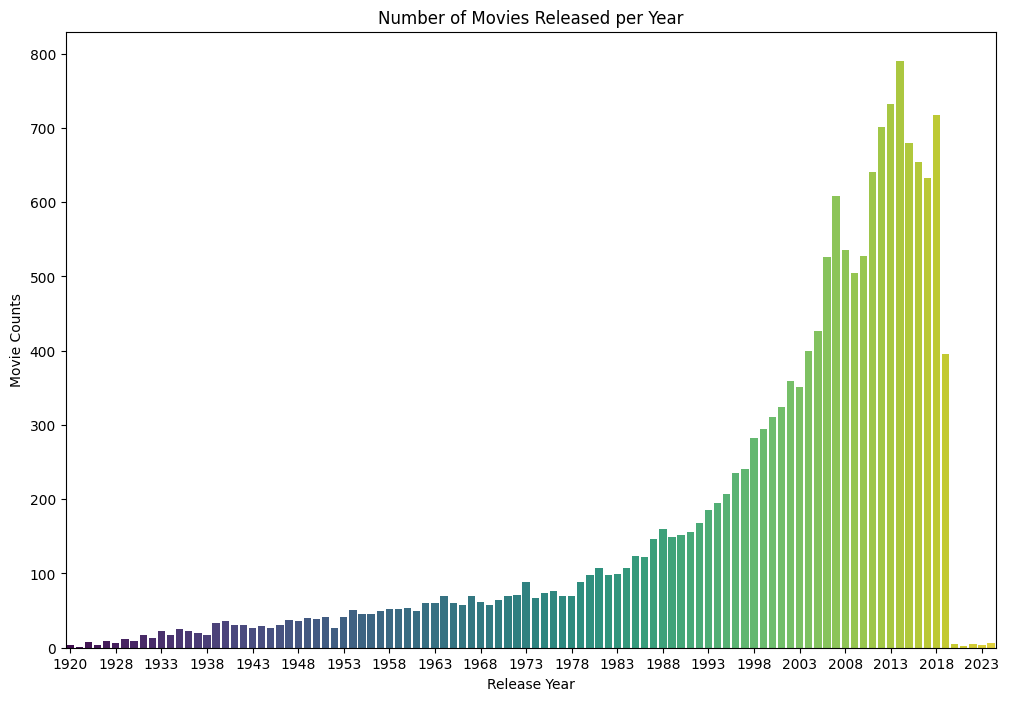

In [13]:
# Visulization
plt.figure(figsize=(12, 8))
sns.barplot(x='release_year', y='count', data=year_counts, palette='viridis')

# Add labels and title
plt.xlabel('Release Year')
plt.ylabel('Movie Counts')
plt.title('Number of Movies Released per Year')
plt.xticks(np.arange(0, len(year_counts), step=5), year_counts['release_year'][::5])
plt.show()

#### Observations from the Bar Chart

1. **Early Years (1920s–1950s)**:
   - The number of movies released per year starts very low, with minimal growth.
   - This period reflects the infancy of the film industry.

2. **Gradual Growth (1950s–1980s)**:
   - A slow but consistent increase in the number of movies released is visible.
   - Likely due to technological advancements, expansion in cinema, and rising global popularity.

3. **Significant Increase (1990s–2010s)**:
   - Starting around the 1990s, the number of movies released per year begins to rise steeply.
   - This corresponds to globalization, the advent of digital filmmaking, and increased production capacity.

4. **Peak and Recent Decline (2010s–2023)**:
   - The peak appears around the 2010s, with the highest number of movies released.
   - A slight decline in recent years could reflect the impact of the COVID-19 pandemic on the film industry.

### 2. Looking only at movies that were released in theatres before 2010:

In [14]:
movies_before_2010 = movies_df[movies_df['release_year'] < 2010]

In [15]:
top_5_critics = movies_before_2010.sort_values(by = 'critic_rating', ascending = False).head(5)
top_5_critics

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year
6794,6751,Gold Diggers of 1933,In this version of Avery Hopwood's theatrical ...,None,Musical & Performing Arts,Mervyn LeRoy,1933-05-27,2006-03-21,96.0,100,10,86.0,2041.0,1933
16572,16572,Young Mr. Lincoln,"In this biography of Abraham Lincoln, the Pres...",None,"Classics, Drama",John Ford,1939-06-09,2006-02-14,100.0,100,22,81.0,2298.0,1939
6795,6752,Gold Diggers of 1935,In this entry in the Gold Diggers musical seri...,G,"Classics, Comedy, Musical & Performing Arts",Lloyd Bacon,1935-03-15,2006-03-21,100.0,100,5,70.0,689.0,1935
7937,10697,On Moonlight Bay,"In this musical, the incorrigible Penrod is pl...",None,"Classics, Comedy, Musical & Performing Arts, R...",Roy Del Ruth,1951-07-26,2007-04-10,95.0,100,5,81.0,681.0,1951
14802,14783,The Return of Martin Guerre (Le Retour de Mart...,This film is set in France during the Hundred ...,None,"Art House & International, Drama, Mystery & Su...",Daniel Vigne,1982-05-15,2019-10-22,123.0,100,15,80.0,2879.0,1982


In [16]:
top_5_audience = movies_before_2010.sort_values(by = 'audience_rating', ascending = False).head(5)
top_5_audience

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year
1846,1801,Ice People,While the mainstream world rolls on indefinite...,None,"Documentary, Special Interest",Anne Aghion,2008-04-26,2009-11-10,77.0,89,9,100.0,37.0,2008
222,216,Prima Ballerina,In the grand tradition of the Ballet Russes co...,None,"Art House & International, Special Interest",Laurent Gentot,2009-01-16,2009-12-08,NaN,81,26,100.0,24.0,2009
3229,3197,Been Rich All My Life,This documentary follows the most unlikely tro...,None,"Documentary, Musical & Performing Arts, Specia...",Heather MacDonald,2006-07-21,2006-11-21,81.0,80,30,100.0,961.0,2006
1283,1289,La Ciudad (The City),This American film (in Spanish) focuses on Lat...,None,"Art House & International, Drama",David Riker,1998-09-13,2005-06-14,88.0,83,12,100.0,313.0,1998
14059,14038,The English Surgeon,The English Surgeon' is the true-life tale of ...,PG,"Art House & International, Documentary, Specia...",Geoffrey Smith,2009-07-31,2009-11-03,93.0,89,19,98.0,3602.0,2009


### 3. Create a new DataFrame containing only “popular” movies that were released in theatres before 2010.

In [17]:
mean_audience = movies_df['audience_count'].dropna().mean()

In [18]:
popular_movies = movies_before_2010[movies_before_2010['audience_count'] > mean_audience]

top_5_critics_pm = popular_movies.sort_values(by = 'critic_rating', ascending = False).head(5)
display(top_5_critics_pm)

top_5_audience_pm = popular_movies.sort_values(by = 'audience_rating', ascending = False).head(5)
display(top_5_audience_pm)

,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year
9636,9588,Mary Poppins,Practically Perfect In Every Way' Mary Poppins...,G,"Classics, Comedy, Kids & Family, Musical & Per...",Robert Stevenson,1964-08-26,1998-03-24,139.0,100,50,86.0,682310.0,1964
15440,15416,Toy Story 2,"Toy Story 2' is the exciting, all-new sequel t...",G,"Animation, Comedy, Kids & Family",John Lasseter,1999-11-24,2000-10-17,92.0,100,169,86.0,999952.0,1999
11227,11194,Pinocchio,When the gentle woodcarver Geppetto (Christian...,G,"Animation, Kids & Family, Musical & Performing...","Hamilton Luske, Ben Sharpsteen, Walt Disney, W...",1940-02-07,2009-03-10,88.0,100,51,73.0,279248.0,1940
13557,13528,The Terminator,A Cyborg has been sent from the future on a de...,R,"Action & Adventure, Science Fiction & Fantasy",James Cameron,1984-10-26,1997-09-03,108.0,100,61,89.0,775856.0,1984
15439,15415,Toy Story,"Woody, a traditional pull-string talking cowbo...",G,"Animation, Comedy, Kids & Family",John Lasseter,1995-11-22,2001-03-20,80.0,100,88,92.0,1109209.0,1995


,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year
12463,12436,The Shawshank Redemption,"In 1946, a banker named Andy Dufresne (Tim Rob...",R,Drama,Frank Darabont,1994-09-10,1998-01-27,142.0,90,71,98.0,885508.0,1994
6747,6704,The Godfather,Popularly viewed as one of the best American f...,R,Drama,Francis Ford Coppola,1972-03-24,2001-10-09,175.0,98,91,98.0,732931.0,1972
6748,6705,"The Godfather, Part II",Francis Ford Coppola's legendary continuation ...,R,"Drama, Mystery & Suspense",Francis Ford Coppola,1974-12-20,2005-05-24,200.0,97,74,97.0,410868.0,1974
5706,5676,Star Wars: Episode V - The Empire Strikes Back,The second entry in George Lucas' Star Wars tr...,PG,"Action & Adventure, Drama, Science Fiction & F...",Irvin Kershner,1980-06-20,2004-09-21,124.0,95,98,97.0,1055106.0,1980
12237,12205,Schindler's List,"Based on a true story, Steven Spielberg's Schi...",R,Drama,Steven Spielberg,1993-12-15,2004-03-09,196.0,97,95,97.0,411166.0,1993


### 4. Using your new DataFrame (popular movies released in theatres before 2010), answer the following questions about the rating column:

• What percent of movies fall under each type of rating (R, PG-13, etc.)?
What are your takeaways from the summary table?

• Create a visualization that shows for each rating (R, PG-13, etc.), the
average critic rating and the average audience rating. What are your
takeaways from the visualization?

In [19]:
popular_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1364 entries, 5 to 16631
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_id            1364 non-null   int64         
 1   movie_title         1364 non-null   object        
 2   movie_info          1364 non-null   object        
 3   rating              1359 non-null   object        
 4   genre               1364 non-null   object        
 5   directors           1359 non-null   object        
 6   in_theaters_date    1364 non-null   datetime64[ns]
 7   on_streaming_date   1364 non-null   datetime64[ns]
 8   runtime_in_minutes  1364 non-null   float64       
 9   critic_rating       1364 non-null   int64         
 10  critic_count        1364 non-null   int64         
 11  audience_rating     1364 non-null   float64       
 12  audience_count      1364 non-null   float64       
 13  release_year        1364 non-null   int64         
d

In [20]:
# Percent of movies fall under each type of rating

cat_count = popular_movies.groupby('rating').size().reset_index(name = 'count')
cat_count['Percentage'] = round(cat_count['count']/cat_count['count'].sum()*100.0,2)
cat_count

,rating,count,Percentage
0,G,79,5.81
1,PG,270,19.87
2,PG-13,540,39.74
3,R,470,34.58


In [21]:
# visualization that shows for each rating, the average critic rating and the average audience rating
rating_averages = popular_movies.groupby('rating')[['critic_rating', 'audience_rating']].mean().reset_index()
rating_averages

,rating,critic_rating,audience_rating
0,G,73.860759,72.696203
1,PG,56.562963,63.551852
2,PG-13,47.940741,61.275926
3,R,62.185106,71.046809


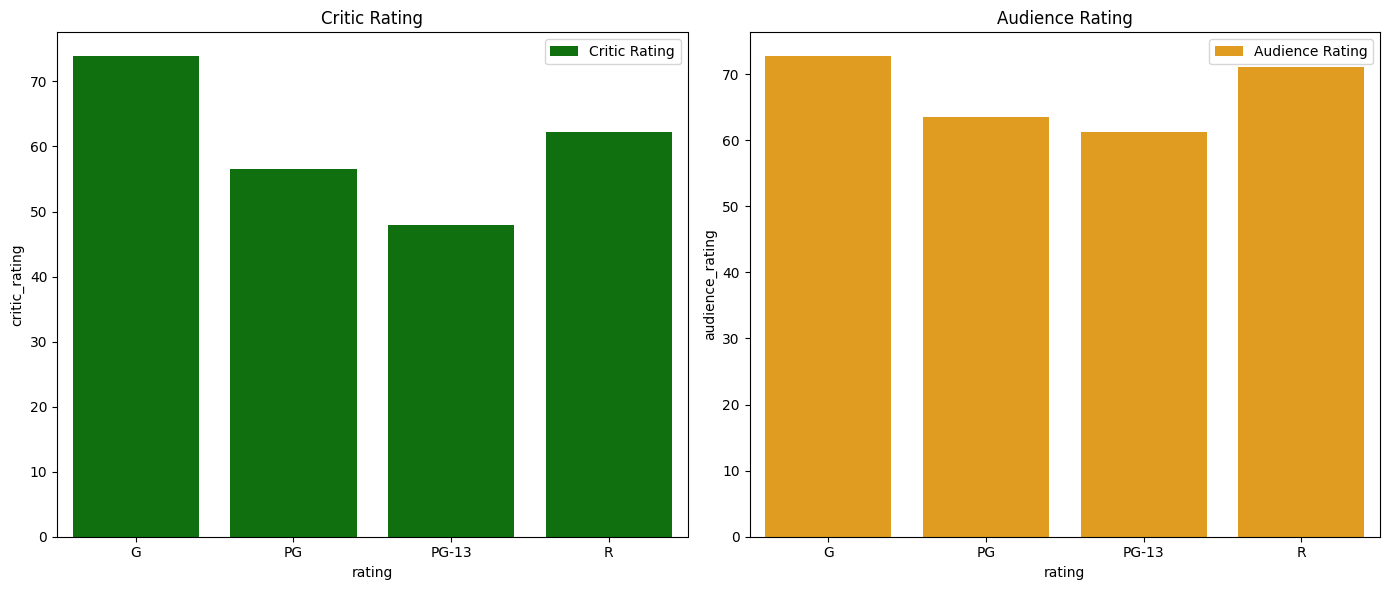

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(ax = axes[0], x='rating', y = 'critic_rating', data = rating_averages, color='green', label='Critic Rating')
axes[0].set_title('Critic Rating')

sns.barplot(ax = axes[1], x='rating', y = 'audience_rating', data = rating_averages, color='orange', label='Audience Rating')
axes[1].set_title('Audience Rating')

plt.tight_layout()
plt.show()

**Key Insights**:
- Critics seem to have a preference for G-rated movies, with progressively lower ratings for higher categories.
- Audiences, on the other hand, do not exhibit the same variability as critics, rating all categories similarly.

### 5. Create a pair plot of the new DataFrame. What are 3 insights you can take away from looking at the pair plot?


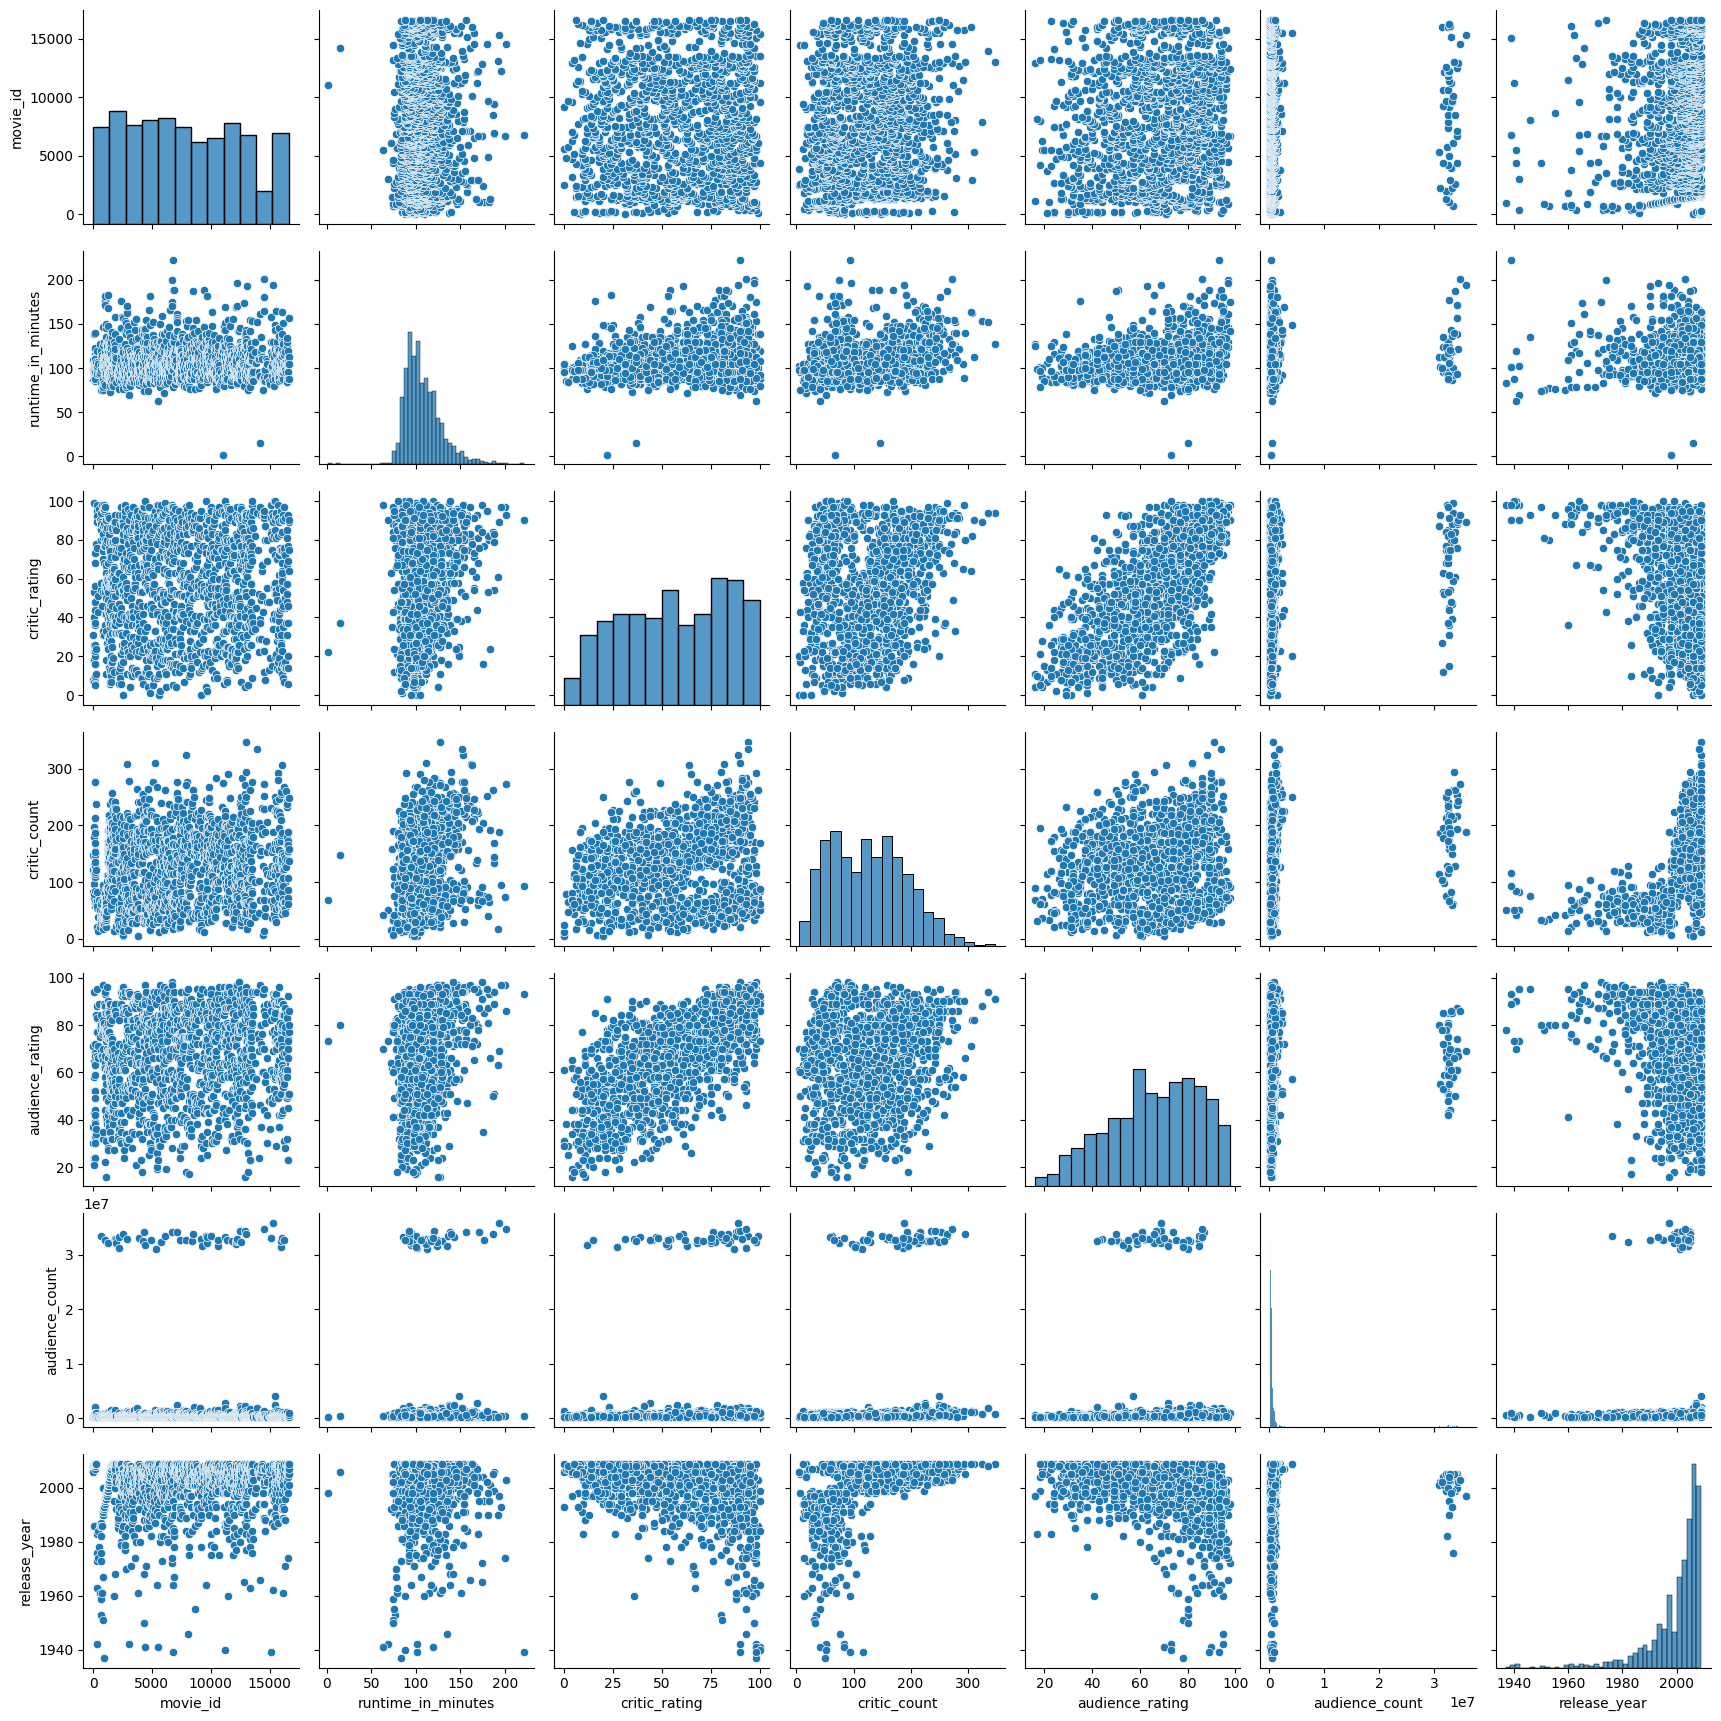

In [23]:
sns.pairplot(popular_movies)
plt.show()

##### **Insights**:

**1. Relationship Between Critic Rating and Audience Rating**:
   - There seems to be a moderate positive correlation between `critic_rating` and `audience_rating`, indicating that movies rated highly by critics tend to be liked by audiences, though not universally.

**2. Review Counts and Release Year**:
   - Movies from earlier release years (e.g., 1940–1980) tend to have lower `critic_count` and `audience_count`. 
   - After a certain point (likely the 2010s), review counts stabilize for most movies
   
**3. Runtime and Ratings**:
   - There is no strong trend between `runtime_in_minutes` and either `critic_rating` or `audience_rating`, though extremely short or long movies might deviate slightly in ratings.
   - Most movies fall within a runtime of 80-150 minutes, with ratings spread across this range.

### 6. Using either pandas or data visualizations, find 3 more insights using any columns in the new DataFrame.

**1. Popular Genres**

In [24]:
popular_critic_genres = popular_movies.groupby('genre')[['critic_count']].mean().sort_values(by='critic_count', ascending=False).reset_index()
popular_audience_genres = popular_movies.groupby('genre')[['audience_count']].mean().sort_values(by='audience_count', ascending=False).reset_index()
display(popular_critic_genres)
display(popular_audience_genres)


,genre,critic_count
0,"Action & Adventure, Drama, Kids & Family, Myst...",276.0
1,"Action & Adventure, Classics, Science Fiction ...",273.0
2,"Action & Adventure, Animation, Comedy, Drama, ...",268.0
3,"Cult Movies, Science Fiction & Fantasy",250.0
4,"Drama, Horror, Mystery & Suspense, Science Fic...",243.0
...,...,...
211,"Classics, Comedy, Kids & Family, Romance",20.0
212,"Horror, Mystery & Suspense, Television",18.0
213,"Action & Adventure, Cult Movies, Drama, Myster...",14.0
214,"Action & Adventure, Animation, Kids & Family, ...",13.0


,genre,audience_count
0,"Action & Adventure, Classics, Science Fiction ...",3.467977e+07
1,"Comedy, Drama, Kids & Family, Romance",3.165973e+07
2,"Comedy, Mystery & Suspense, Science Fiction & ...",3.098457e+07
3,"Drama, Horror, Mystery & Suspense, Romance",1.632585e+07
4,"Kids & Family, Science Fiction & Fantasy",1.158983e+07
...,...,...
211,"Action & Adventure, Art House & International,...",1.779290e+05
212,"Classics, Comedy, Kids & Family, Romance",1.745970e+05
213,"Comedy, Western",1.710680e+05
214,"Kids & Family, Romance",1.596410e+05


**1. Critics and Audiences Align**: Popular genres like "Action & Adventure" consistently rank high in both critic and audience counts.

**2. Divergence in Interest**: Some genres (e.g., "Art House & International") gain attention from critics but less from audiences, highlighting a gap in appeal.

**2. Yearly Trends in Ratings**

<Axes: xlabel='release_year'>

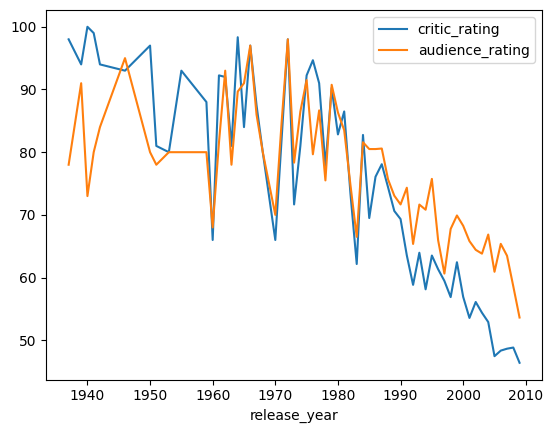

In [25]:
yearly_ratings = popular_movies.groupby('release_year')[['critic_rating', 'audience_rating']].mean()
yearly_ratings.plot()

1. **Critic Ratings Volatility**: Critic ratings show more fluctuations across the decades and a sharper decline after the 1980s.

2. **Modern Gap (Post-2000)**: The divergence between critics and audience ratings becomes increasingly pronounced, suggesting differing opinions on modern films.

**3. Relationship Between Runtime and Ratings**

In [26]:
runtime_corr = popular_movies[['runtime_in_minutes', 'critic_rating', 'audience_rating']].corr()
runtime_corr

,runtime_in_minutes,critic_rating,audience_rating
runtime_in_minutes,1.000000,0.279660,0.338515
critic_rating,0.279660,1.000000,0.714903
audience_rating,0.338515,0.714903,1.000000


**Insight:** Critic and audience ratings have the strongest relationship, while runtime shows weak correlations with both rating types.

### Additional data cleaning beside instruction

In [27]:
# Rating has many missing values, using tmdb to map the content rating
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16503 entries, 0 to 16637
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_id            16503 non-null  int64         
 1   movie_title         16503 non-null  object        
 2   movie_info          16480 non-null  object        
 3   rating              11751 non-null  object        
 4   genre               16487 non-null  object        
 5   directors           16395 non-null  object        
 6   in_theaters_date    16503 non-null  datetime64[ns]
 7   on_streaming_date   16503 non-null  datetime64[ns]
 8   runtime_in_minutes  16356 non-null  float64       
 9   critic_rating       16503 non-null  int64         
 10  critic_count        16503 non-null  int64         
 11  audience_rating     16277 non-null  float64       
 12  audience_count      16282 non-null  float64       
 13  release_year        16503 non-null  int64         


In [28]:
# Find title with missing rating
rating_titles = movies_df[movies_df['rating'].isna()]['movie_title'].to_list()

In [29]:
reload(tmdbmovie)

from tmdbmovie import fetch_missing_ratings
ratings_dict  =  fetch_missing_ratings(rating_titles, region = 'US')

Fetching rating for: 12 Angry Men (Twelve Angry Men)
Fetching rating for: The 39 Steps
Fetching rating for: 3:10 to Yuma
Fetching rating for: Abraham Lincoln
Fetching rating for: The Breaking Point
Fetching rating for: Adam's Rib
Fetching rating for: Jamaica Inn
Fetching rating for: Man Hunt
Fetching rating for: The Cool School
Fetching rating for: Wild Side
Fetching rating for: A Farewell To Arms
Fetching rating for: The Narrow Margin
Fetching rating for: The Alamo
Fetching rating for: All Quiet on the Western Front
Fetching rating for: Independent Lens
Fetching rating for: Street Fight
Fetching rating for: The Motel
Fetching rating for: Anna Karenina
Fetching rating for: Requiem
Fetching rating for: The 4th Dimension
Fetching rating for: Snow Blind
Fetching rating for: Delirious
Fetching rating for: Alexandra
Fetching rating for: Road to Victory
Fetching rating for: King Corn
Fetching rating for: Laaga Chunari Mein Daag - Journey of a Woman
Fetching rating for: Aaja Nachle
Fetching r

In [30]:
ratings_dict

{'12 Angry Men (Twelve Angry Men)': 'NR',
 'The 39 Steps': 'NR',
 '3:10 to Yuma': 'R',
 'Abraham Lincoln': 'R',
 'The Breaking Point': 'NR',
 "Adam's Rib": 'NR',
 'Jamaica Inn': 'NR',
 'Man Hunt': 'NR',
 'The Cool School': 'G',
 'Wild Side': 'Not Rated',
 'A Farewell To Arms': 'NR',
 'The Narrow Margin': 'NR',
 'The Alamo': 'PG-13',
 'All Quiet on the Western Front': 'R',
 'Independent Lens': 'Not Rated',
 'Street Fight': 'PG-13',
 'The Motel': 'Not Rated',
 'Anna Karenina': 'R',
 'Requiem': 'Not Rated',
 'The 4th Dimension': 'Not Rated',
 'Snow Blind': 'R',
 'Delirious': 'PG',
 'Alexandra': 'Not Rated',
 'Road to Victory': 'Not Rated',
 'King Corn': 'G',
 'Laaga Chunari Mein Daag - Journey of a Woman': 'Not Rated',
 'Aaja Nachle': 'Not Rated',
 'Meeting Resistance': 'Not Rated',
 'Guta-yubalja-deul (A Bloody Aria)': 'Not Rated',
 'La Graine et le Mulet (The Secret of the Grain) (Couscous)': 'Not Rated',
 "The Duchess of Langeais (Ne Touchez Pas La Hache)(Don't Touch the Axe)": 'Not Ra

In [31]:
movies_df.loc[movies_df['rating'].isna(), 'rating'] = movies_df['movie_title'].map(ratings_dict)

In [32]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16503 entries, 0 to 16637
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_id            16503 non-null  int64         
 1   movie_title         16503 non-null  object        
 2   movie_info          16480 non-null  object        
 3   rating              16330 non-null  object        
 4   genre               16487 non-null  object        
 5   directors           16395 non-null  object        
 6   in_theaters_date    16503 non-null  datetime64[ns]
 7   on_streaming_date   16503 non-null  datetime64[ns]
 8   runtime_in_minutes  16356 non-null  float64       
 9   critic_rating       16503 non-null  int64         
 10  critic_count        16503 non-null  int64         
 11  audience_rating     16277 non-null  float64       
 12  audience_count      16282 non-null  float64       
 13  release_year        16503 non-null  int64         


In [ ]:
# map these missing values to Not Rated
movies_df['rating'].isna().sum()

np.int64(173)

In [52]:
movies_df.loc[movies_df['rating'].isna(), 'rating'] = 'Not Rated'
movies_df['rating'].isna().sum()

np.int64(0)

In [ ]:
## Svae cleaned original df to pickle file

# movies_df.to_pickle(cleaned_pickle_file_path)
# print("DataFrame saved to 'movies_df_cleaned.pkl'")

DataFrame saved to 'movies_df_cleaned.pkl'
